# Ensembling and Stacking

http://mlwave.com/kaggle-ensembling-guide/

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys

import csv
import datetime
import itertools
import numpy as np
import pandas as pd
import random
import re
import sklearn
import time
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(rc={
       "figure.figsize": (16, 10),
       "axes.titlesize": 14})

from IPython.display import Image, display
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

from os.path import expanduser
sys.path.insert(1, '{}/datsci'.format(expanduser('~')))
from datsci import eda, munge, ml, ensemble
from datsci import kaggle as kg, ml

In [2]:
import santander

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import SGDClassifier as SGDClf
from sklearn.cross_validation import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

import xgboost as xgb

## Creating ensembles from submission files

In [7]:
fnames = [
    'submissions/xgb.fine_tuned.dedup.csv',
    'submissions/xgb.fine_tuned.dedup.fit_all.csv',
    'submissions/xgb.fine_tuned.dedup.fit_all_cv.csv',
    'submissions/xgb.fine_tuned.1hot.csv',
    'submissions/xgb.fine_tuned.1hot.fit_all.csv',
    'submissions/xgb.fine_tuned.1hot.fit_all_cv.csv',
    'submissions/xgb.fine_tuned.deltanan.csv',
    'submissions/xgb.fine_tuned.deltanan.fit_all.csv',
    'submissions/xgb.fine_tuned.deltanan.fit_all_cv.csv']

### Weighted Average (Submission Bagging)

In [3]:
!ls submissions | cat

avg_1hot_deltanan_unweighted.csv
avg_1hot_deltanan_weighted.csv
xgb.fine_tuned.1hot.csv
xgb.fine_tuned.1hot.fit_all.csv
xgb.fine_tuned.1hot.fit_all_cv.csv
xgb.fine_tuned.dedup.csv
xgb.fine_tuned.dedup.fit_all.csv
xgb.fine_tuned.dedup.fit_all_cv.csv
xgb.fine_tuned.deltanan.csv
xgb.fine_tuned.deltanan.fit_all.csv
xgb.fine_tuned.deltanan.fit_all_cv.csv


In [ ]:
# Unweighted average

# Score 0.838476
y_hat_avg = kg.weighted_avg_from_files(
    fnames,
    "submissions/avg_1hot_deltanan_unweighted.csv",
    weights=[],
    sample_submission_file='data/sample_submission.csv',
    sample_submission_idx='ID'
)

In [5]:
# Weight the heavily fine-tuned ones more

# Score 0.838588
y_hat_avg = kg.weighted_avg_from_files(
    fnames,
    "submissions/avg_1hot_deltanan_weighted.csv",
    weights=[1, 1, 2, 1, 1, 3],
    sample_submission_file='data/sample_submission.csv',
    sample_submission_idx='ID'
)

### Voting

Not fit for regression

### Correlation

Find highly uncorrelated predictions and average them

In [8]:
y_hats = pd.DataFrame([pd.read_csv(f, index_col='ID', squeeze=True).rename(f) for f in fnames]).T

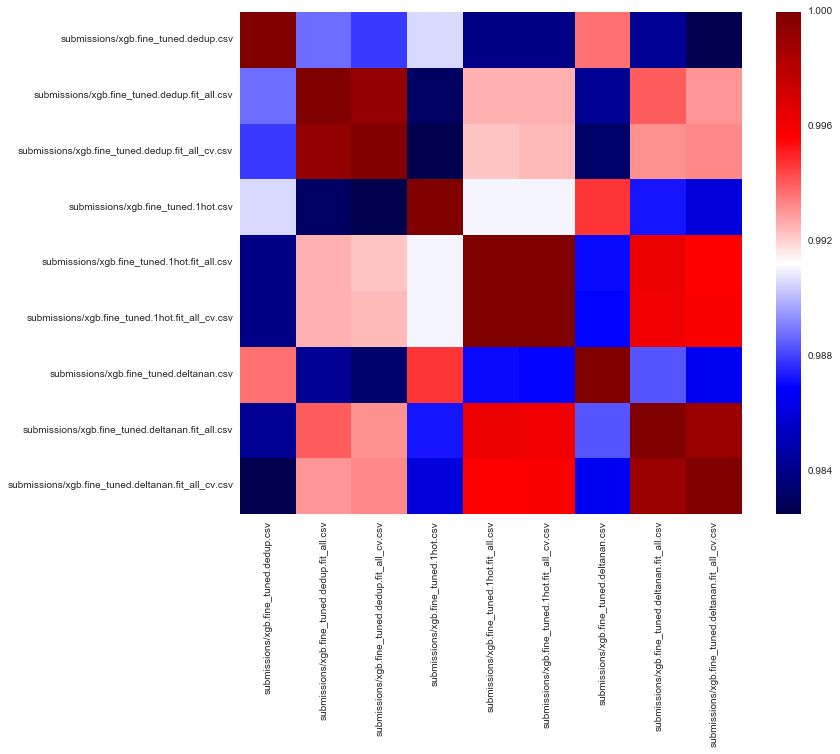

In [9]:
corr = eda.corr_heat(y_hats)

In [10]:
# Unweighted average of most uncorrelated results

# High Score 0.839078
fnames_uncorr = [
    'submissions/xgb.fine_tuned.dedup.fit_all_cv.csv',
    'submissions/xgb.fine_tuned.deltanan.fit_all_cv.csv'
]
y_hat_avg = kg.weighted_avg_from_files(
    fnames_uncorr,
    "submissions/avg_dedup_uncorrelated.csv",
    weights=[],
    sample_submission_file='data/sample_submission.csv',
    sample_submission_idx='ID'
)

In [11]:
# Unweighted average of most uncorrelated results

# Score 0.838835
fnames_uncorr = [
    'submissions/xgb.fine_tuned.dedup.fit_all_cv.csv',
    'submissions/xgb.fine_tuned.deltanan.csv'
]
y_hat_avg = kg.weighted_avg_from_files(
    fnames_uncorr,
    "submissions/avg_dedup_uncorrelated2.csv",
    weights=[],
    sample_submission_file='data/sample_submission.csv',
    sample_submission_idx='ID'
)

In [14]:
# Unweighted average of most uncorrelated results

# Score 0.838991
fnames_uncorr = [
    'submissions/xgb.fine_tuned.dedup.fit_all_cv.csv',
    'submissions/xgb.fine_tuned.deltanan.fit_all_cv.csv',
    'submissions/xgb.fine_tuned.1hot.fit_all.csv'
]
y_hat_avg = kg.weighted_avg_from_files(
    fnames_uncorr,
    "submissions/avg_dedup_uncorrelated3.csv",
    weights=[],
    sample_submission_file='data/sample_submission.csv',
    sample_submission_idx='ID'
)

## Stacked Generalization

In [29]:
import copy

model = xgb.XGBRegressor(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
    objective='binary:logistic',
    nthread=4,
    seed=santander.RANDOM_SEED
)
# model = xgb.XGBRegressor(
#     learning_rate=0.01,
#     n_estimators=5000,
#     max_depth=7,
#     min_child_weight=6,
#     gamma=0,
#     subsample=0.8,
#     colsample_bytree=0.68,
#     colsample_bylevel=0.82,
#     reg_alpha=0,
#     reg_lambda=1,
#     scale_pos_weight=1,
#     max_delta_step=0,
#     objective='binary:logistic',
#     nthread=4,
#     seed=santander.RANDOM_SEED
# )


# Read in data
X_train, y_train, X_test, y_test, feature_cols, df_train, df_test = santander.read_split(
    santander.FILE_TRAIN_DEDUP,
    santander.FILE_TEST_DEDUP,
    test_size=0.1,
    random_state=santander.RANDOM_SEED
)
X_train1, X_train2, y_train1, y_train2 = santander.train_test_split(
        X_train, y_train, test_size=0.5, random_state=santander.RANDOM_SEED, stratify=y_train)


# Train first half
model1 = copy.deepcopy(model)
n_estimators, train_score, test_score = ml.cv_fit_xgb_model(
    model1, X_train1, y_train1, X_test, y_test, cv_nfold=5, early_stopping_rounds=50,
    scorer=roc_auc_score, verbose=True
)
model1.n_estimators = n_estimators


# Train second half
model2 = copy.deepcopy(model)
n_estimators, train_score, test_score = ml.cv_fit_xgb_model(
    model2, X_train2, y_train2, X_test, y_test, cv_nfold=5, early_stopping_rounds=50,
    scorer=roc_auc_score, verbose=True
)
model2.n_estimators = n_estimators


# Train all
model3 = copy.deepcopy(model)

n_estimators, train_score, test_score = ml.cv_fit_xgb_model(
    model3, X_train, y_train, X_test, y_test, cv_nfold=5, early_stopping_rounds=50,
    scorer=roc_auc_score, verbose=True
)
model3.n_estimators = n_estimators

Will train until cv error hasn't decreased in 50 rounds.
/usr/local/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]
Stopping. Best iteration: 683



Model Report
best n_estimators: 684
Score (Train): 0.896414
Score (Test) : 0.835780


Will train until cv error hasn't decreased in 50 rounds.
/usr/local/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]
Stopping. Best iteration: 568



Model Report
best n_estimators: 569
Score (Train): 0.888095
Score (Test) : 0.840615


Will train until cv error hasn't decreased in 50 rounds.
/usr/local/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]
Stopping. Best iteration: 894



Model Report
best n_estimators: 895
Score (Train): 0.885021
Score (Test) : 0.838038


In [30]:
# Stack

X_train_stack = pd.DataFrame([m.predict(X_train) for m in (model1, model2, model3)]).T
X_valid_stack = pd.DataFrame([m.predict(X_test) for m in (model1, model2, model3)]).T
X_test_stack = pd.DataFrame([m.predict(df_test) for m in (model1, model2, model3)]).T

n_estimators, train_score, test_score = ml.cv_fit_xgb_model(
    model, X_train_stack, y_train, X_valid_stack, y_test, cv_nfold=5, early_stopping_rounds=50,
    scorer=roc_auc_score, verbose=True
)

model.n_estimators = n_estimators

# Save prediction
kg.save_submission(model.predict(X_test_stack), 'submissions/stack1.csv')  # Score 

Will train until cv error hasn't decreased in 50 rounds.
/usr/local/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]
Stopping. Best iteration: 478



Model Report
best n_estimators: 479
Score (Train): 0.894385
Score (Test) : 0.829815


In [31]:
# Nonlinear stacking

models = (model1, model2, model3)
X_train_stack = pd.DataFrame([m.predict(X_train) for m in models]).T
X_valid_stack = pd.DataFrame([m.predict(X_test) for m in models]).T
X_test_stack = pd.DataFrame([m.predict(df_test) for m in models]).T

for i in range(len(models)):
    X_train['stack{}'.format(i)] = X_train_stack[i].values
    X_test['stack{}'.format(i)] = X_valid_stack[i].values
    df_test['stack{}'.format(i)] = X_test_stack[i].values

n_estimators, train_score, test_score = ml.cv_fit_xgb_model(
    model, X_train, y_train, X_test, y_test, cv_nfold=5, early_stopping_rounds=50,
    scorer=roc_auc_score, verbose=True
)

model.n_estimators = n_estimators

# Save prediction
kg.save_submission(model.predict(df_test), 'submissions/stack1.csv')  # Score 

Will train until cv error hasn't decreased in 50 rounds.
/usr/local/lib/python3.5/site-packages/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]



Model Report
best n_estimators: 479
Score (Train): 0.914431
Score (Test) : 0.832748


## Blending